![](https://miro.medium.com/max/1224/1*064lT1SXq_6F7uoc00V1fw.gif)

# Introduction

![](https://static.packt-cdn.com/products/9781789345377/graphics/2770c767-b801-4225-a0af-0761808742a9.jpg)

If you need to tackle a very complex problem, such as detecting hundreds of types of objects in high-resolution images? You may need to train a much deeper DNN, perhaps with (say) 10 layers, each containing hundreds of neurons, connected by hundreds of thousands of connections. First, you would be faced with the tricky vanishing gradients problem (or the related exploding gradients problem) that affects deep neural networks and makes lower layers very hard to train. Second, with such a large network, training would be extremely slow. Third, a model with millions of parameters would severely risk overfitting the training set.

In this Notebook, I will go through each of these problems in turn and present techniques to solve them.

**Topics Covered in this Notebook**

* Vanishing Gradients Problems : Different Weight Initialization
* Nonsaturating Activation Functions : ReLU, LeakyReLU,RReLU,PReLU,ELU,SELU
* Batch Normalization
* Exploding Gradients Problems : Gradient Clipping
* Optimizers : Momentum, RMSProp, ADAM, NADAM, ADAMAX, NESTEROV
* Learning Rate Schedulers : Power Scheduler, Exponential, Performance and PieceWise
* l1 and l2 Regularizers
* DropOut Regularization
* MaxNorm Regularization

> All the implementation are done in TensorFlow and Keras.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras

# Data Acquisition

> I am using fashion MNIST data which contain 10 classes and 70000 images of shape 28*28

In [3]:
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

# Utilities

> I am making a plot function to plot different metrics after each training. So that we can visualize our results.

In [5]:
def plot(h):
    plt.style.use('seaborn-darkgrid')

    epochs = h.epoch

    acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    fig = plt.figure(figsize = (6,4),dpi = 100)
    ax = fig.add_axes([1,1,1,1])

    ax.plot(epochs,acc,label = 'Accuracy')
    ax.plot(epochs,val_acc,label = 'Val Accuracy')

    ax.plot(epochs,loss,label = 'Loss')
    ax.plot(epochs,val_loss,label = 'Val Loss')
    
    ax.set(xlabel = 'Number of Epochs',ylabel = 'Measure',title = 'Learning Curve')

    ax.legend()

# Simple Model

> Let us make a very simple model first and then we will start tweaking different parameters and architecture.

In [6]:
#Create Model
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, activation='relu'),                                    
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')
])

#Define Optimizer
sgd = tf.keras.optimizers.SGD(lr = 0.001)

#Compile Model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

> Let us see the architecture of model by using plot_model function.

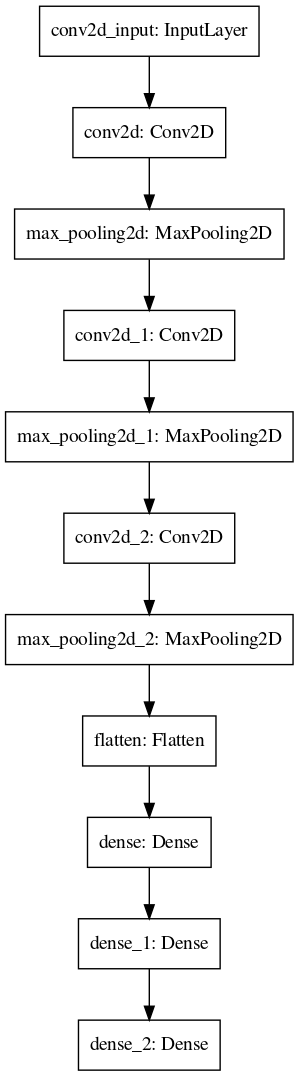

In [13]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False,dpi=100)

In [14]:
#Train Model
h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 7s 4ms/step - loss: 2.2932 - accuracy: 0.1336 - val_loss: 2.2823 - val_accuracy: 0.2234
Epoch 2/25
1875/1875 [==============================] - 6s 3ms/step - loss: 2.2583 - accuracy: 0.2858 - val_loss: 2.2172 - val_accuracy: 0.3259
Epoch 3/25
1875/1875 [==============================] - 6s 3ms/step - loss: 2.0012 - accuracy: 0.4190 - val_loss: 1.5277 - val_accuracy: 0.5176
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.1916 - accuracy: 0.5782 - val_loss: 1.0599 - val_accuracy: 0.6070
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9787 - accuracy: 0.6411 - val_loss: 0.9372 - val_accuracy: 0.6589
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8751 - accuracy: 0.6811 - val_loss: 0.8589 - val_accuracy: 0.6855
Epoch 7/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8083 - accuracy: 0.7050 - val_loss: 0.8212 - val_accuracy:

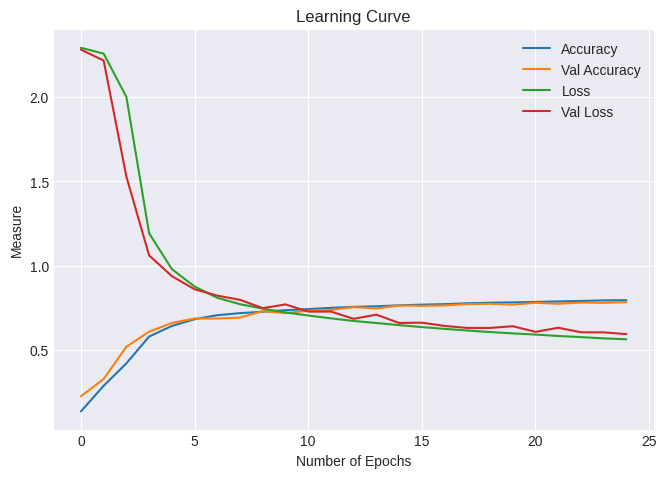

In [15]:
plot(h)

# He Initialization

We just simply multiply random initialization with :

![](https://miro.medium.com/max/700/1*zxD6Nr6TyAb8JEG6oXAjkg.png)

> To implement in Keras , Just use kernel_initializer = 'he_normal'

In [16]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu',kernel_initializer = 'he_normal', input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu',kernel_initializer = 'he_normal'),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu',kernel_initializer = 'he_normal'),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, activation='relu',kernel_initializer = 'he_normal'),                                    
                                    tf.keras.layers.Dense(128, activation='relu',kernel_initializer = 'he_normal'),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.001)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.1209 - accuracy: 0.6324 - val_loss: 0.8032 - val_accuracy: 0.7030
Epoch 2/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7277 - accuracy: 0.7323 - val_loss: 0.7151 - val_accuracy: 0.7138
Epoch 3/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6530 - accuracy: 0.7589 - val_loss: 0.6792 - val_accuracy: 0.7399
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6090 - accuracy: 0.7758 - val_loss: 0.6050 - val_accuracy: 0.7824
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5775 - accuracy: 0.7895 - val_loss: 0.5733 - val_accuracy: 0.7948
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5536 - accuracy: 0.7995 - val_loss: 0.5657 - val_accuracy: 0.7955
Epoch 7/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5324 - accuracy: 0.8077 - val_loss: 0.5322 - val_accuracy:

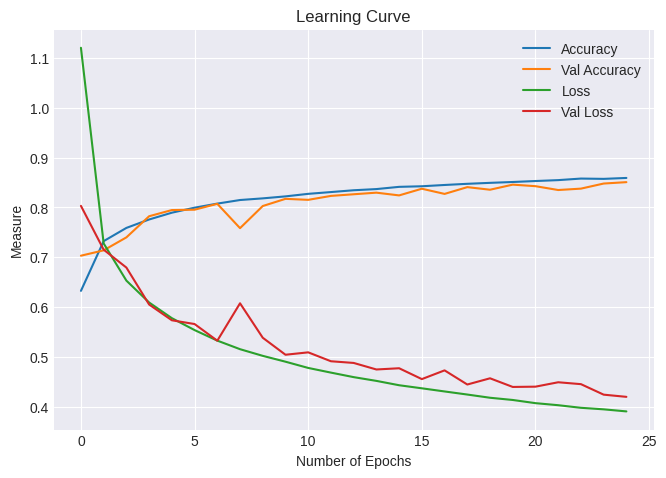

In [17]:
plot(h)

# Leaky ReLU

![](https://i0.wp.com/androidkt.com/wp-content/uploads/2020/05/Selection_019.png?resize=760%2C364)

This function is defined as LeakyReLU α (z) = max(αz, z) (see Figure). The hyperparameter α defines how much the function “leaks”: it is the slope of the function for z < 0, and is typically set to 0.01. This small slope ensures that leaky ReLUs never die.

> To implement this, Just use this layer instead of Activation Function parameter : tf.keras.layers.LeakyReLU(alpha = 0.2) where alpha is Leak.

In [18]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.001)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.0065 - accuracy: 0.6636 - val_loss: 0.7455 - val_accuracy: 0.7346
Epoch 2/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6684 - accuracy: 0.7548 - val_loss: 0.6477 - val_accuracy: 0.7689
Epoch 3/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6064 - accuracy: 0.7783 - val_loss: 0.6012 - val_accuracy: 0.7857
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5711 - accuracy: 0.7912 - val_loss: 0.5759 - val_accuracy: 0.7923
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5464 - accuracy: 0.8013 - val_loss: 0.5649 - val_accuracy: 0.7970
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5263 - accuracy: 0.8087 - val_loss: 0.5355 - val_accuracy: 0.8090
Epoch 7/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5076 - accuracy: 0.8162 - val_loss: 0.5234 - val_accuracy:

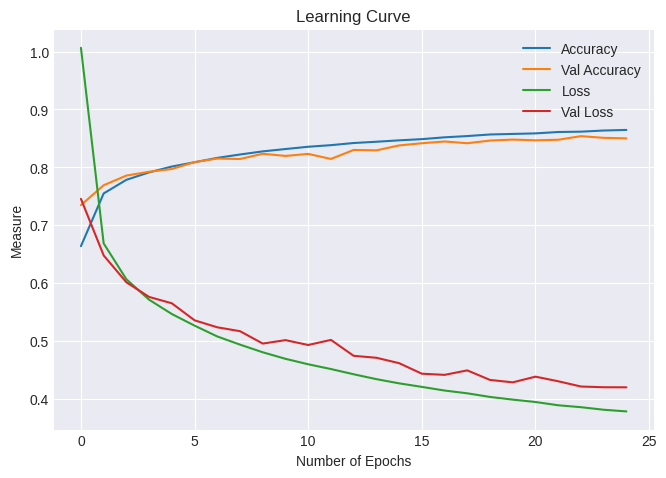

In [19]:
plot(h)

# PReLU

![](https://imgs.developpaper.com/imgs/2813863991-5e720eab30026_articlex.png)

Parametric leaky ReLU (PReLU), where α is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). This was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.

> To implement this, Just use this layer instead of Activation Function parameter : tf.keras.layers.PReLU()

In [20]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.PReLU(),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.PReLU(),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.PReLU(),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal'),
                                    tf.keras.layers.PReLU(),

                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal'),
                                    tf.keras.layers.PReLU(),
                                    
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.001)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 7s 4ms/step - loss: 1.0170 - accuracy: 0.6529 - val_loss: 0.7702 - val_accuracy: 0.7266
Epoch 2/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7020 - accuracy: 0.7428 - val_loss: 0.6920 - val_accuracy: 0.7534
Epoch 3/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6357 - accuracy: 0.7674 - val_loss: 0.6238 - val_accuracy: 0.7797
Epoch 4/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5980 - accuracy: 0.7820 - val_loss: 0.6137 - val_accuracy: 0.7780
Epoch 5/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5704 - accuracy: 0.7940 - val_loss: 0.5792 - val_accuracy: 0.7916
Epoch 6/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5474 - accuracy: 0.8019 - val_loss: 0.5538 - val_accuracy: 0.8006
Epoch 7/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5290 - accuracy: 0.8077 - val_loss: 0.5498 - val_accuracy:

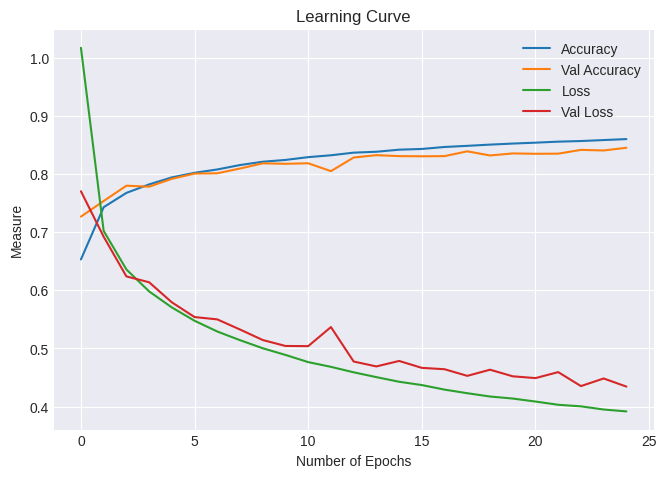

In [21]:
plot(h)

# ELU Activation Function

![](https://360digit.b-cdn.net/assets/admin/ckfinder/userfiles/images/blog/elu.png)

It looks a lot like the ReLU function, with a few major differences:

1. First it takes on negative values when z < 0, which allows the unit to have an average output closer to 0. This helps alleviate the vanishing gradients problem, as discussed earlier. The hyperparameter α defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter if you want.

2. Second, it has a nonzero gradient for z < 0, which avoids the dying units issue.

3. Third, the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent, since it does not bounce as much left and right of z = 0.

> To implement this, Just use this layer instead of Activation Function parameter : tf.keras.layers.ELU()

In [22]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.ELU(),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.ELU(),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.ELU(),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal'),
                                    tf.keras.layers.ELU(),

                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal'),
                                    tf.keras.layers.ELU(),
                                    
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.001)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8917 - accuracy: 0.6934 - val_loss: 0.6783 - val_accuracy: 0.7611
Epoch 2/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6234 - accuracy: 0.7741 - val_loss: 0.6150 - val_accuracy: 0.7784
Epoch 3/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5708 - accuracy: 0.7943 - val_loss: 0.5854 - val_accuracy: 0.7946
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5386 - accuracy: 0.8060 - val_loss: 0.5444 - val_accuracy: 0.8073
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5146 - accuracy: 0.8136 - val_loss: 0.5564 - val_accuracy: 0.8031
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4962 - accuracy: 0.8215 - val_loss: 0.5155 - val_accuracy: 0.8190
Epoch 7/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4791 - accuracy: 0.8265 - val_loss: 0.4989 - val_accuracy:

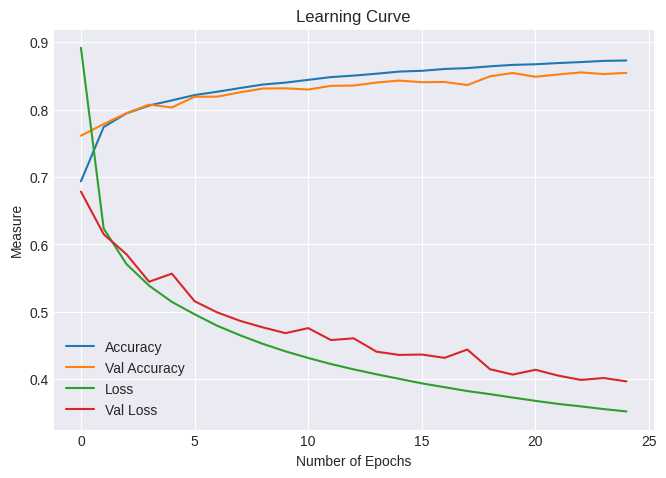

In [23]:
plot(h)

# Batch Normalization

![](https://images.deepai.org/glossary-terms/981e1ffea3814ae193c27461253faf63/batch_normalization.png)

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

The technique consists of adding an operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new parameters per layer (one for scaling, the other for shifting). In other words, this operation lets the model learn the optimal scale and mean of the inputs for each layer.

> To implement simply use this layer tf.keras.layers.batch_normalization(). We can apply BN Layer before activation function or even after activation function. It depends on work, So it is better to try both and compare results.

## BN After Activation Function

In [24]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.001)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.8862 - accuracy: 0.6938 - val_loss: 0.6701 - val_accuracy: 0.7657
Epoch 2/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6497 - accuracy: 0.7711 - val_loss: 0.6124 - val_accuracy: 0.7848
Epoch 3/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5854 - accuracy: 0.7906 - val_loss: 0.5460 - val_accuracy: 0.8042
Epoch 4/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5443 - accuracy: 0.8062 - val_loss: 0.5218 - val_accuracy: 0.8127
Epoch 5/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5179 - accuracy: 0.8157 - val_loss: 0.4991 - val_accuracy: 0.8233
Epoch 6/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4978 - accuracy: 0.8229 - val_loss: 0.4877 - val_accuracy: 0.8243
Epoch 7/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4809 - accuracy: 0.8295 - val_loss: 0.4747 - val_accuracy:

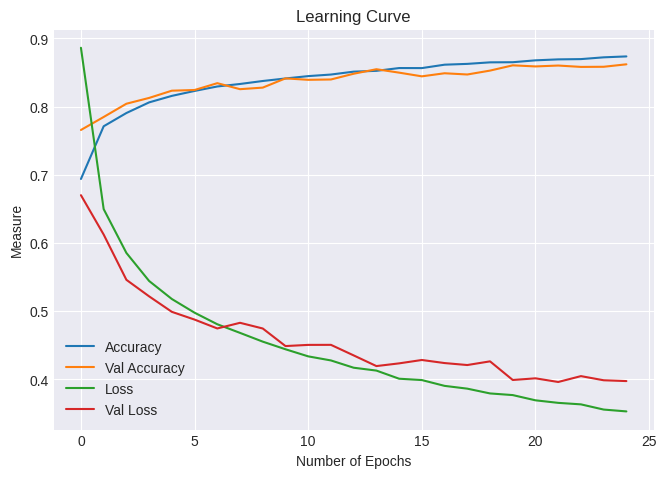

In [25]:
plot(h)

# BN Before Activation Function

In [26]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.BatchNormalization(),                                    
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.001)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 1.0179 - accuracy: 0.6679 - val_loss: 0.7316 - val_accuracy: 0.7516
Epoch 2/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7019 - accuracy: 0.7602 - val_loss: 0.6245 - val_accuracy: 0.7840
Epoch 3/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6195 - accuracy: 0.7864 - val_loss: 0.5676 - val_accuracy: 0.8010
Epoch 4/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5711 - accuracy: 0.8024 - val_loss: 0.5343 - val_accuracy: 0.8119
Epoch 5/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5385 - accuracy: 0.8109 - val_loss: 0.5157 - val_accuracy: 0.8176
Epoch 6/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5136 - accuracy: 0.8198 - val_loss: 0.5036 - val_accuracy: 0.8224
Epoch 7/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4959 - accuracy: 0.8261 - val_loss: 0.4843 - val_accuracy:

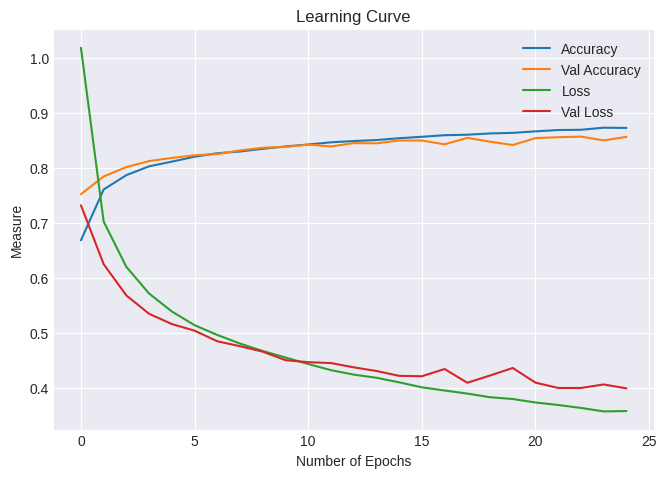

In [27]:
plot(h)

# Gradient Clipping

A popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold.

> In Keras, Implementing Gradient Clipping is just setting clipvalue or cleepnorm argument when creating optimizer. Please read more about difference between cleepvalue and cleepnorm over Google.

## Clip By Value

In [28]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.001,clipvalue = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.8738 - accuracy: 0.6985 - val_loss: 0.6574 - val_accuracy: 0.7699
Epoch 2/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6411 - accuracy: 0.7724 - val_loss: 0.5847 - val_accuracy: 0.7894
Epoch 3/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5814 - accuracy: 0.7921 - val_loss: 0.5573 - val_accuracy: 0.7981
Epoch 4/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5427 - accuracy: 0.8075 - val_loss: 0.5172 - val_accuracy: 0.8156
Epoch 5/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5157 - accuracy: 0.8160 - val_loss: 0.5186 - val_accuracy: 0.8122
Epoch 6/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4973 - accuracy: 0.8221 - val_loss: 0.4814 - val_accuracy: 0.8271
Epoch 7/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4793 - accuracy: 0.8281 - val_loss: 0.4708 - val_accuracy:

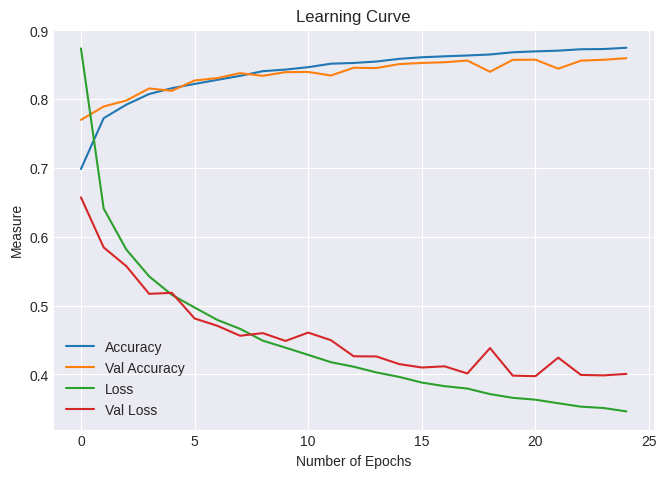

In [29]:
plot(h)

## Clip by Norm

In [30]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.001,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 1.1895 - accuracy: 0.5972 - val_loss: 0.8097 - val_accuracy: 0.7141
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.7800 - accuracy: 0.7228 - val_loss: 0.6998 - val_accuracy: 0.7453
Epoch 3/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.7007 - accuracy: 0.7463 - val_loss: 0.6572 - val_accuracy: 0.7595
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6590 - accuracy: 0.7606 - val_loss: 0.6172 - val_accuracy: 0.7776
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6270 - accuracy: 0.7728 - val_loss: 0.5957 - val_accuracy: 0.7862
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6042 - accuracy: 0.7824 - val_loss: 0.5776 - val_accuracy: 0.7947
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5882 - accuracy: 0.7880 - val_loss: 0.5702 - val_accuracy

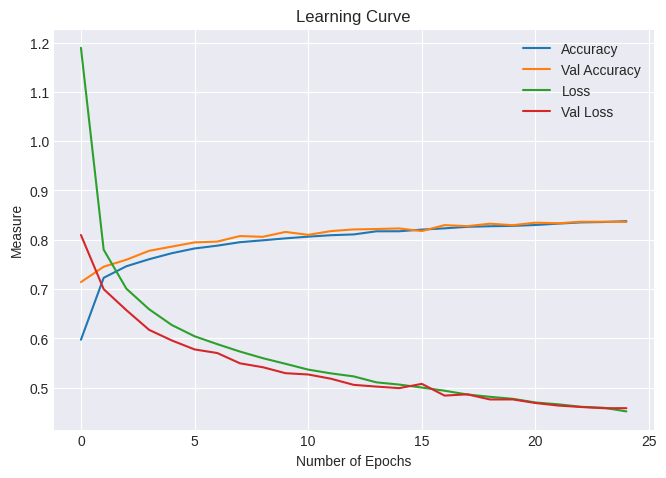

In [31]:
plot(h)

# Momentum Optimizer

![](https://mlfromscratch.com/content/images/2019/12/momentum.gif)

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the very simple idea behind Momentum optimization.Momentum optimization cares a great deal about what previous gradients were?

![](https://blog.paperspace.com/content/images/2018/06/momentum2-1.png)

To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter β, simply called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

> Implementing in Keras is easier just use momentum Parameter : sgd = tf.keras.optimizers.SGD(lr = 0.001,momentum = 0.90,clipnorm = 1.0)

In [34]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.001,momentum = 0.90,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.7102 - accuracy: 0.7491 - val_loss: 0.5575 - val_accuracy: 0.7993
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5039 - accuracy: 0.8192 - val_loss: 0.5317 - val_accuracy: 0.8018
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4482 - accuracy: 0.8395 - val_loss: 0.4991 - val_accuracy: 0.8173
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4149 - accuracy: 0.8504 - val_loss: 0.4745 - val_accuracy: 0.8356
Epoch 5/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3907 - accuracy: 0.8594 - val_loss: 0.4134 - val_accuracy: 0.8517
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3691 - accuracy: 0.8667 - val_loss: 0.4171 - val_accuracy: 0.8539
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3539 - accuracy: 0.8723 - val_loss: 0.4614 - val_accuracy

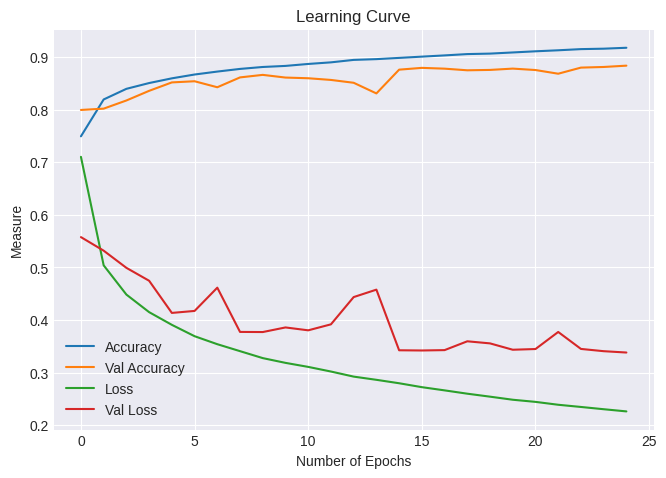

In [35]:
plot(h)

# Nesterov Optimizer

![](https://image.slidesharecdn.com/2dwfpvwoswquxlfmgkvr-signature-a67e94e385b0f51ee716eaa6622e12490992bac90a7a1bf9ae2be66c7fac4b82-poli-160812071230/95/08-distributed-optimization-9-638.jpg?cb=1470986354)

One small variant to Momentum optimization, proposed by Yurii Nesterov in 1983, 12 is almost always faster than vanilla Momentum optimization. The idea of Nesterov Momentum optimization, or Nesterov Accelerated Gradient (NAG), is to measure the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum.

> To implement in tf.keras , Just use nesterov = True parameter : sgd = tf.keras.optimizers.SGD(lr = 0.001,momentum = 0.90,nesterov = True,clipnorm = 1.0)

In [36]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.001,momentum = 0.90,nesterov = True,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6999 - accuracy: 0.7499 - val_loss: 0.5372 - val_accuracy: 0.8026
Epoch 2/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5135 - accuracy: 0.8136 - val_loss: 0.5097 - val_accuracy: 0.8158
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4577 - accuracy: 0.8344 - val_loss: 0.4580 - val_accuracy: 0.8346
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4304 - accuracy: 0.8443 - val_loss: 0.4681 - val_accuracy: 0.8314
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4052 - accuracy: 0.8521 - val_loss: 0.4839 - val_accuracy: 0.8237
Epoch 6/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3878 - accuracy: 0.8574 - val_loss: 0.4567 - val_accuracy: 0.8416
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3743 - accuracy: 0.8632 - val_loss: 0.4130 - val_accurac

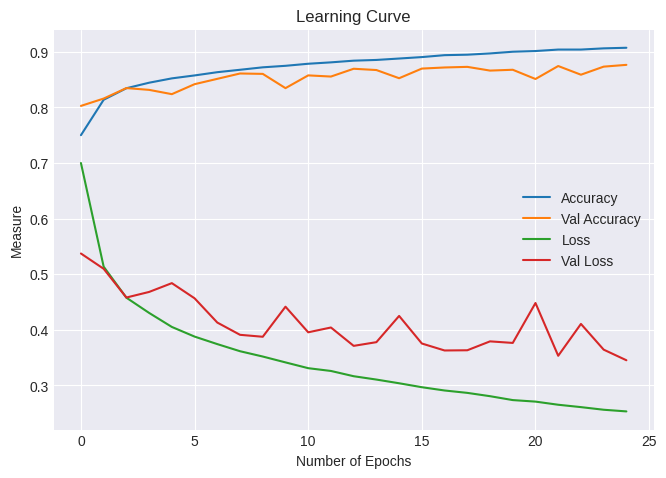

In [37]:
plot(h)

# RMSProp Optimizer

![](https://mlfromscratch.com/content/images/2019/12/rmsprop.gif)

The RMSprop optimizer is similar to the gradient descent algorithm with momentum. The RMSprop optimizer restricts the oscillations in the vertical direction. Therefore, we can increase our learning rate and our algorithm could take larger steps in the horizontal direction converging faster. The difference between RMSprop and gradient descent is on how the gradients are calculated. The following equations show how the gradients are calculated for the RMSprop and gradient descent with momentum. The value of momentum is denoted by beta and is usually set to 0.9. If you are not interested in the math behind the optimizer :-

![](https://miro.medium.com/max/524/1*m_PC8M4y9UKYU9JNuOC9Jw.png)

> Implementation in Keras : rms = tf.keras.optimizers.RMSprop(lr = 0.001,rho = 0.90,clipnorm = 1.0)

In [38]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


rms = tf.keras.optimizers.RMSprop(lr = 0.001,rho = 0.90,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = rms,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.5220 - accuracy: 0.8119 - val_loss: 0.5007 - val_accuracy: 0.8269
Epoch 2/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3689 - accuracy: 0.8665 - val_loss: 0.4025 - val_accuracy: 0.8619
Epoch 3/25
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3199 - accuracy: 0.8834 - val_loss: 0.3384 - val_accuracy: 0.8763
Epoch 4/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2880 - accuracy: 0.8955 - val_loss: 0.3388 - val_accuracy: 0.8809
Epoch 5/25
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2679 - accuracy: 0.9030 - val_loss: 0.3240 - val_accuracy: 0.8848
Epoch 6/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2482 - accuracy: 0.9092 - val_loss: 0.3131 - val_accuracy: 0.8939
Epoch 7/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2327 - accuracy: 0.9146 - val_loss: 0.3093 - val_ac

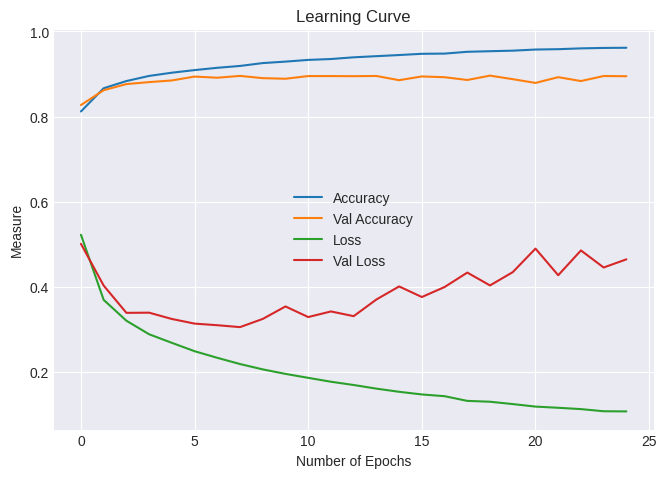

In [39]:
plot(h)

# ADAM Optimizer

![](https://miro.medium.com/max/960/1*nuoD-tQylhMj-SF8WJfUjg.gif)

Adam, stands for adaptive moment estimation, combines the ideas of Momentum optimization and RMSProp: just like Momentum optimization it keeps track of an exponentially decaying average of past gradients, and just like RMSProp it keeps track of an exponentially decaying average of past squared gradients.

### Adam Configuration Parameters

alpha : Also referred to as the learning rate or step size. The proportion that weights are updated (e.g.0.001). Larger values (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values (e.g. 1.0E-5) slow learning right down during training

beta1 : The exponential decay rate for the first moment estimates (e.g. 0.9).

beta2 : The exponential decay rate for the second-moment estimates (e.g. 0.999). This value should be set close to 1.0 on problems with a sparse gradient (e.g. NLP and computer vision problems).

epsilon : Is a very small number to prevent any division by zero in the implementation (e.g. 10E-8).

> Implementation in Keras : adam = tf.keras.optimizers.Adam(lr = 0.001,beta_1 = 0.9,beta_2=0.999,clipnorm = 1.0)

In [40]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


adam = tf.keras.optimizers.Adam(lr = 0.001,beta_1 = 0.9,beta_2=0.999,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5123 - accuracy: 0.8156 - val_loss: 0.4414 - val_accuracy: 0.8342
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3625 - accuracy: 0.8686 - val_loss: 0.3899 - val_accuracy: 0.8528
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3122 - accuracy: 0.8846 - val_loss: 0.3388 - val_accuracy: 0.8750
Epoch 4/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2819 - accuracy: 0.8970 - val_loss: 0.3446 - val_accuracy: 0.8770
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2602 - accuracy: 0.9037 - val_loss: 0.3104 - val_accuracy: 0.8857
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2394 - accuracy: 0.9121 - val_loss: 0.3398 - val_accuracy: 0.8790
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2230 - accuracy: 0.9174 - val_loss: 0.3081 - val_accuracy

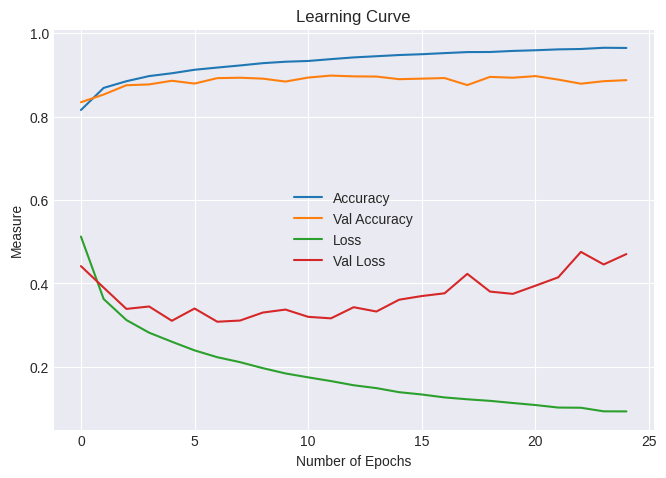

In [41]:
plot(h)

# AdaMax Optimizer
Adamax was introduced by the authors of Adam in the same paper. The idea with Adamax is to look at the value v as the L2 norm of the individual current and past gradients. We can generalize it to Lp update rule, but it gets pretty unstable for large values of p. But if we use the special case of L-infinity norm, it results in a surprisingly stable and well-performing algorithm. Here’s how to implement Adamax with python:

> admx = tf.keras.optimizers.Adamax(lr = 0.001,beta_1 = 0.9,beta_2=0.999,clipnorm = 1.0)

In [42]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


admx = tf.keras.optimizers.Adamax(lr = 0.001,beta_1 = 0.9,beta_2=0.999,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = admx,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5451 - accuracy: 0.8055 - val_loss: 0.4732 - val_accuracy: 0.8247
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4012 - accuracy: 0.8541 - val_loss: 0.4131 - val_accuracy: 0.8508
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3567 - accuracy: 0.8699 - val_loss: 0.3986 - val_accuracy: 0.8552
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3252 - accuracy: 0.8810 - val_loss: 0.4211 - val_accuracy: 0.8580
Epoch 5/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3032 - accuracy: 0.8885 - val_loss: 0.3663 - val_accuracy: 0.8747
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2823 - accuracy: 0.8965 - val_loss: 0.3551 - val_accuracy: 0.8738
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2676 - accuracy: 0.9026 - val_loss: 0.3577 - val_accuracy

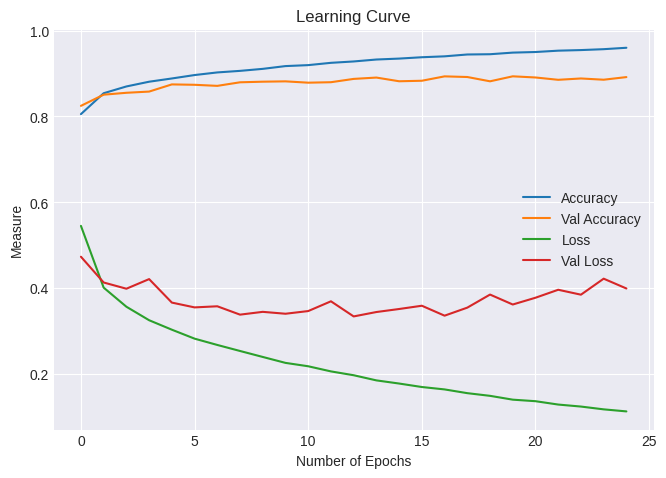

In [43]:
plot(h)

# NADAM Optimizer
Nadam combines NAG and Adam.Nadam is employed for noisy gradients or for gradients with high curvatures The learning process is accelerated by summing up the exponential decay of the moving averages for the previous and current gradient.

> Implementing NADAM : ndm = tf.keras.optimizers.Nadam(lr = 0.001,beta_1 = 0.9,beta_2=0.999,clipnorm = 1.0)

In [44]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


ndm = tf.keras.optimizers.Nadam(lr = 0.001,beta_1 = 0.9,beta_2=0.999,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = ndm,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.5092 - accuracy: 0.8162 - val_loss: 0.3991 - val_accuracy: 0.8581
Epoch 2/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3652 - accuracy: 0.8682 - val_loss: 0.3974 - val_accuracy: 0.8559
Epoch 3/25
1875/1875 [==============================] - 12s 7ms/step - loss: 0.3189 - accuracy: 0.8830 - val_loss: 0.3555 - val_accuracy: 0.8719
Epoch 4/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2857 - accuracy: 0.8952 - val_loss: 0.3256 - val_accuracy: 0.8818
Epoch 5/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2624 - accuracy: 0.9034 - val_loss: 0.3179 - val_accuracy: 0.8880
Epoch 6/25
1875/1875 [==============================] - 12s 7ms/step - loss: 0.2437 - accuracy: 0.9113 - val_loss: 0.3552 - val_accuracy: 0.8751
Epoch 7/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2269 - accuracy: 0.9150 - val_loss: 0.3017 - val_ac

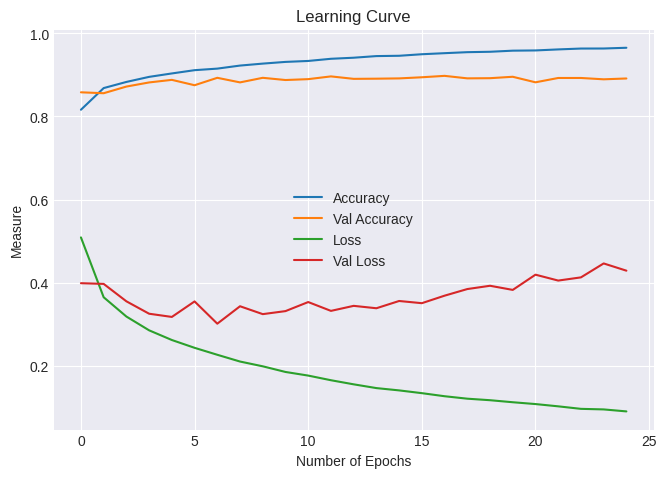

In [45]:
plot(h)

> Let us compare these optimizers with a GIF

![](https://2.bp.blogspot.com/-q6l20Vs4P_w/VPmIC7sEhnI/AAAAAAAACC4/g3UOUX2r_yA/s1600/s25RsOr%2B-%2BImgur.gif)

# Learning Rate Schedulers

Finding a good learning rate can be tricky. If you set it way too high, training may actually diverge. If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never settling down (unless you use an adaptive learning rate optimization algorithm such as AdaGrad, RMSProp, or Adam, but even then it may take time to settle).

You can do better than a constant learning rate: if you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. These strategies are called learning schedules.

# Power Scheduling

Set the learning rate to η(t) = η 0 (1 + t/r) –c . The hyperparameter c is typically set to 1. This is
similar to exponential scheduling, but the learning rate drops much more slowly.

> To Implement use decay Parameter : sgd = tf.keras.optimizers.SGD(lr = 0.01,clipnorm = 1.0,decay = 1e-4)

In [46]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.01,clipnorm = 1.0,decay = 1e-4)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6899 - accuracy: 0.7558 - val_loss: 0.5214 - val_accuracy: 0.8131
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5028 - accuracy: 0.8209 - val_loss: 0.4956 - val_accuracy: 0.8193
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4528 - accuracy: 0.8370 - val_loss: 0.4415 - val_accuracy: 0.8438
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4226 - accuracy: 0.8482 - val_loss: 0.4339 - val_accuracy: 0.8416
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4048 - accuracy: 0.8541 - val_loss: 0.4149 - val_accuracy: 0.8499
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3881 - accuracy: 0.8604 - val_loss: 0.4282 - val_accuracy: 0.8469
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3750 - accuracy: 0.8649 - val_loss: 0.4034 - val_accuracy

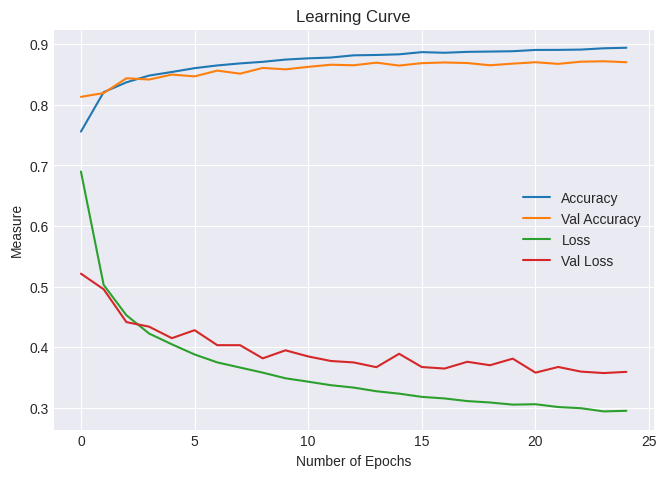

In [47]:
plot(h)

# Exponential Scheduling

Set the learning rate to a function of the iteration number t: η(t) = η 0 10 –t/r . This works great, but it
requires tuning η 0 and r. The learning rate will drop by a factor of 10 every r steps.

In [48]:
def exp_decay_function(epoch):
    return 0.01*(0.1**(epoch / 20))

lr = tf.keras.callbacks.LearningRateScheduler(exp_decay_function)

In [49]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.01,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32,callbacks = [lr])

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.7041 - accuracy: 0.7489 - val_loss: 0.5432 - val_accuracy: 0.8039 - lr: 0.0100
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5110 - accuracy: 0.8154 - val_loss: 0.5188 - val_accuracy: 0.8078 - lr: 0.0089
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4594 - accuracy: 0.8346 - val_loss: 0.4703 - val_accuracy: 0.8333 - lr: 0.0079
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4309 - accuracy: 0.8450 - val_loss: 0.4469 - val_accuracy: 0.8371 - lr: 0.0071
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4077 - accuracy: 0.8520 - val_loss: 0.4210 - val_accuracy: 0.8473 - lr: 0.0063
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3923 - accuracy: 0.8592 - val_loss: 0.4167 - val_accuracy: 0.8532 - lr: 0.0056
Epoch 7/25
1875/1875 [==============================] - 9s

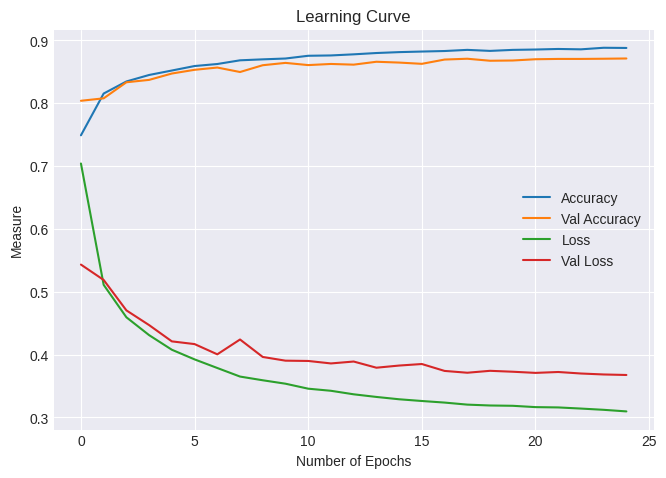

In [50]:
plot(h)

# Piecewise Constant Scheduling

For example, set the learning rate to η 0 = 0.1 at first, then to η 1 = 0.001 after 50 epochs. Although this solution can work very well, it often requires fiddling around to figure out the right learning rates and when to use them.

In [51]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

lr = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

In [52]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.01,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32,callbacks = [lr])

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.7149 - accuracy: 0.7443 - val_loss: 0.5726 - val_accuracy: 0.7969 - lr: 0.0100
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5196 - accuracy: 0.8120 - val_loss: 0.5033 - val_accuracy: 0.8201 - lr: 0.0100
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4627 - accuracy: 0.8333 - val_loss: 0.5008 - val_accuracy: 0.8185 - lr: 0.0100
Epoch 4/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4276 - accuracy: 0.8456 - val_loss: 0.4345 - val_accuracy: 0.8434 - lr: 0.0100
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4033 - accuracy: 0.8549 - val_loss: 0.4473 - val_accuracy: 0.8378 - lr: 0.0100
Epoch 6/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3755 - accuracy: 0.8637 - val_loss: 0.4046 - val_accuracy: 0.8519 - lr: 0.0050
Epoch 7/25
1875/1875 [==============================] - 9

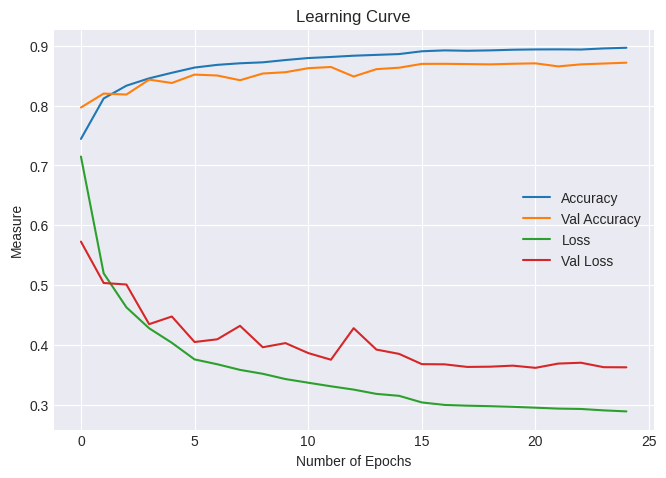

In [53]:
plot(h)

# Performance Scheduling

Measure the validation error every N steps (just like for early stopping) and reduce the learning rate by a factor of λ when the error stops dropping. Multiplly learning rate by 0.5 with patience 5.

In [54]:
lr = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 5)

In [55]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.01,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32,callbacks = [lr])

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6909 - accuracy: 0.7535 - val_loss: 0.5379 - val_accuracy: 0.8034 - lr: 0.0100
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5045 - accuracy: 0.8187 - val_loss: 0.5544 - val_accuracy: 0.7961 - lr: 0.0100
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4518 - accuracy: 0.8382 - val_loss: 0.4483 - val_accuracy: 0.8408 - lr: 0.0100
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4171 - accuracy: 0.8486 - val_loss: 0.4289 - val_accuracy: 0.8487 - lr: 0.0100
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3949 - accuracy: 0.8581 - val_loss: 0.5082 - val_accuracy: 0.8205 - lr: 0.0100
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3778 - accuracy: 0.8643 - val_loss: 0.4214 - val_accuracy: 0.8514 - lr: 0.0100
Epoch 7/25
1875/1875 [==============================] - 9s

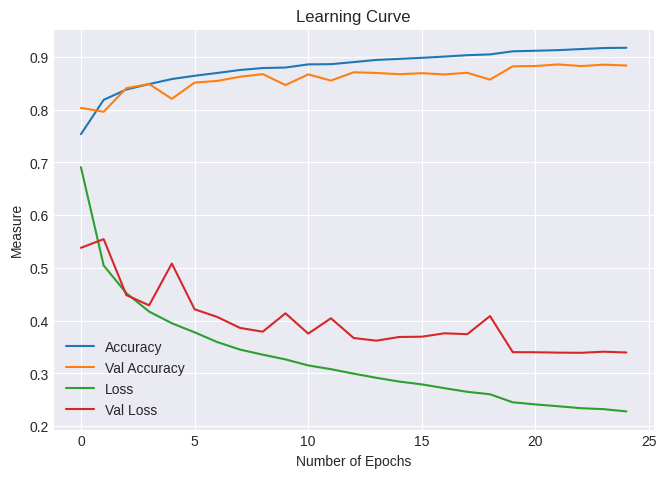

In [56]:
plot(h)

# L1 and L2 Regularizers

Regularisation is a process of introducing additional information in order to prevent overfitting.If you have studied the concept of regularization in machine learning, you will have a fair idea that regularization penalizes the coefficients. In deep learning, it actually penalizes the weight matrices of the nodes.

> Implementation : Use kernel_regularizer = tf.keras.regularizers.l2(0.001)

In [57]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',kernel_regularizer = tf.keras.regularizers.l2(0.001),use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',kernel_regularizer = tf.keras.regularizers.l2(0.001),use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.01,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 10s 5ms/step - loss: 1.4474 - accuracy: 0.7522 - val_loss: 1.3221 - val_accuracy: 0.7891
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 1.2149 - accuracy: 0.8164 - val_loss: 1.1579 - val_accuracy: 0.8302
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 1.1123 - accuracy: 0.8360 - val_loss: 1.1150 - val_accuracy: 0.8269
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 1.0414 - accuracy: 0.8483 - val_loss: 1.0525 - val_accuracy: 0.8321
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.9797 - accuracy: 0.8539 - val_loss: 0.9690 - val_accuracy: 0.8545
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.9235 - accuracy: 0.8628 - val_loss: 0.9561 - val_accuracy: 0.8430
Epoch 7/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.8736 - accuracy: 0.8680 - val_loss: 0.8721 - val_accurac

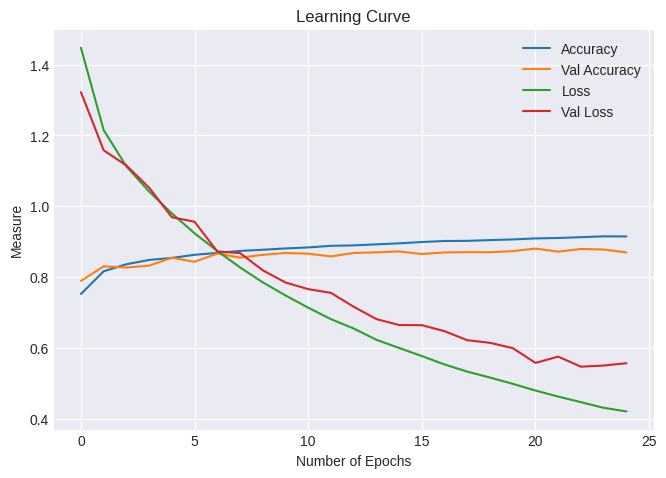

In [58]:
plot(h)

# Dropout Regularization

![](https://miro.medium.com/max/1224/1*064lT1SXq_6F7uoc00V1fw.gif)

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons but excluding the output neurons) has a probability p of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step (see Figure 11-9). The hyperparameter p is called the dropout rate, and it is typically set to 50%. After training, neurons don’t get dropped anymore.

> Implementation : Simple use a layer : tf.keras.layers.Dropout(0.2)

In [59]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',use_bias = False),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.01,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.9137 - accuracy: 0.6784 - val_loss: 0.5738 - val_accuracy: 0.7947
Epoch 2/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6230 - accuracy: 0.7761 - val_loss: 0.5458 - val_accuracy: 0.8088
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5463 - accuracy: 0.8055 - val_loss: 0.4900 - val_accuracy: 0.8245
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5049 - accuracy: 0.8187 - val_loss: 0.4800 - val_accuracy: 0.8285
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4756 - accuracy: 0.8306 - val_loss: 0.4673 - val_accuracy: 0.8353
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4521 - accuracy: 0.8387 - val_loss: 0.4180 - val_accuracy: 0.8500
Epoch 7/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4333 - accuracy: 0.8449 - val_loss: 0.4255 - val_accurac

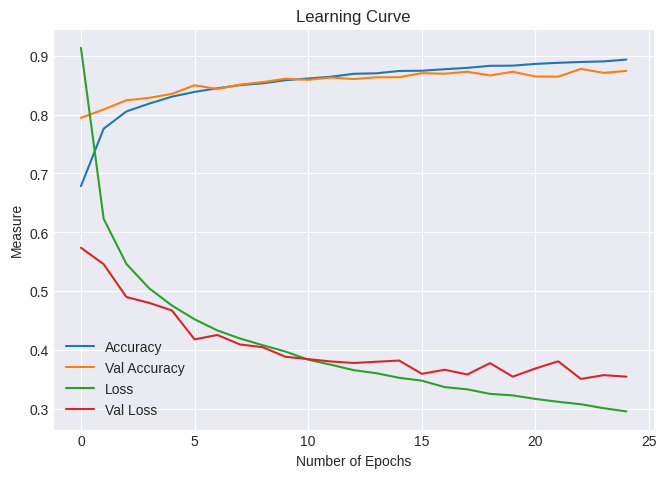

In [60]:
plot(h)

# Max Norm Regularization

Another regularization technique that is quite popular for neural networks is called max-norm regularization: for each neuron, it constrains the weights w of the incoming connections such that r, where r is the max-norm hyperparameter and · 2 is the l 2 norm. We typically implement this constraint by computing

needed (w 2 ≤ w 2 after each training step and clipping w if). Reducing r increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the vanishing/exploding gradients problems (if you are not using Batch Normalization).

> Implementation in Keras : kernel_constraint = tf.keras.constraints.max_norm(1.)

In [61]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3),kernel_initializer = 'he_normal',input_shape=(28, 28, 1)),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3),kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer = 'he_normal'),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    tf.keras.layers.MaxPooling2D(2,2),
  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(256, kernel_initializer = 'he_normal',kernel_constraint = tf.keras.constraints.max_norm(1.),use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),

                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128, kernel_initializer = 'he_normal',kernel_constraint = tf.keras.constraints.max_norm(1.),use_bias = False),
                                    tf.keras.layers.LeakyReLU(alpha = 0.2),
                                    
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation='softmax')
])


sgd = tf.keras.optimizers.SGD(lr = 0.01,clipnorm = 1.0)

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

h = model.fit(training_images,training_labels,
          epochs=25,batch_size = 32,steps_per_epoch = 60000//32,
          validation_data = (test_images,test_labels),validation_steps = 10000//32)

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6907 - accuracy: 0.7538 - val_loss: 0.5504 - val_accuracy: 0.8006
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5051 - accuracy: 0.8179 - val_loss: 0.4782 - val_accuracy: 0.8299
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4559 - accuracy: 0.8358 - val_loss: 0.4639 - val_accuracy: 0.8360
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4206 - accuracy: 0.8466 - val_loss: 0.4318 - val_accuracy: 0.8445
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3966 - accuracy: 0.8559 - val_loss: 0.4466 - val_accuracy: 0.8416
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3779 - accuracy: 0.8622 - val_loss: 0.4245 - val_accuracy: 0.8479
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3620 - accuracy: 0.8689 - val_loss: 0.4619 - val_accuracy:

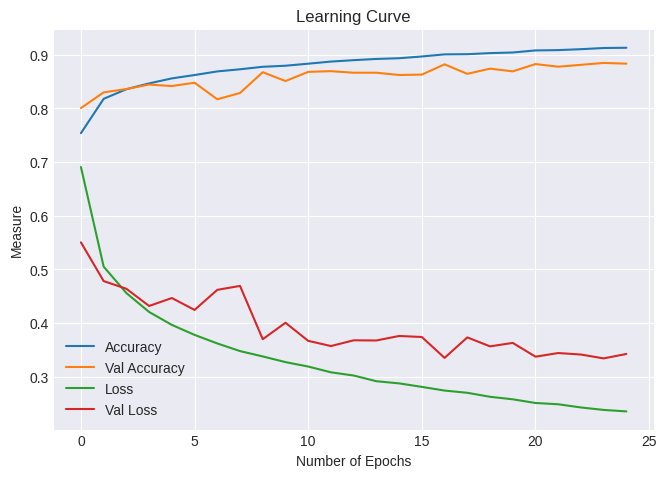

In [62]:
plot(h)

> **Thank you for reading my Notebook, I hope this is useful in some way. Good Luck for future!!**